# CIFAR-10 Autoencoder

We will create a convolutional autoencoder for the [CIFAR10](https://www.tensorflow.org/datasets/catalog/cifar10) dataset.

## Imports

In [1]:
try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow.keras.models import Sequential

2021-09-16 16:54:01.839230: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


## Load and prepare the dataset

The [CIFAR 10](https://www.tensorflow.org/datasets/catalog/cifar10) dataset already has train and test splits.

In [2]:
# preprocessing function
def map_image(image, label):
    image = tf.cast(image, dtype=tf.float32)
    image = image / 255.0

    return image, image # dataset label is not used. replaced with the same image input.

# parameters
BATCH_SIZE = 128
SHUFFLE_BUFFER_SIZE = 1024

# using tfds.load() to fetch the 'train' split of CIFAR-10
train_dataset = tfds.load('cifar10', split='train', as_supervised=True)

# preprocess the dataset with the `map_image()` function above
train_dataset = train_dataset.map(map_image)

# shuffle and batch the dataset
train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)


# using tfds.load() to fetch the 'test' split of CIFAR-10
test_dataset = tfds.load('cifar10', split='test', as_supervised=True)

# preprocess the dataset with the `map_image()` function above
test_dataset = test_dataset.map(map_image)

# batch the dataset
test_dataset = test_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

/opt/conda/lib/python3.7/site-packages/urllib3/connectionpool.py:1020: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.cs.toronto.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,


0 examples [00:00, ? examples/s]

2021-09-16 16:54:10.991680: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-09-16 16:54:10.995126: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-09-16 16:54:11.040492: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-16 16:54:11.041115: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 681.88GiB/s
2021-09-16 16:54:11.041168: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-09-16 16:54:11.064833: I tensorflow/stream_executor/platform/def

Shuffling and writing examples to /root/tensorflow_datasets/cifar10/3.0.2.incompleteXXCZGP/cifar10-train.tfrecord


  0%|          | 0/50000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cifar10/3.0.2.incompleteXXCZGP/cifar10-test.tfrecord


  0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


## Build the Model

Create the autoencoder model. We want to downsample the image in the encoder layers then upsample it in the decoder path. Note that the output layer should be the same dimensions as the original image. Our input images will have the shape `(32, 32, 3)`.

In [3]:
def encoder(inputs):
    '''Defines the encoder with two Conv2D and max pooling layers.'''
    conv_1 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same')(inputs)
    max_pool_1 = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(conv_1)

    conv_2 = tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same')(max_pool_1)
    max_pool_2 = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(conv_2)

    return max_pool_2

def bottle_neck(inputs):
    '''Defines the bottleneck.'''
    bottle_neck = tf.keras.layers.Conv2D(filters=256, kernel_size=(3,3), activation='relu', padding='same')(inputs)
    encoder_visualization = tf.keras.layers.Conv2D(filters=1, kernel_size=(3,3), activation='sigmoid', padding='same')(bottle_neck)

    return bottle_neck, encoder_visualization

def decoder(inputs):
    '''Defines the decoder path to upsample back to the original image size.'''
    conv_1 = tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same')(inputs)
    up_sample_1 = tf.keras.layers.UpSampling2D(size=(2,2))(conv_1)

    conv_2 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same')(up_sample_1)
    up_sample_2 = tf.keras.layers.UpSampling2D(size=(2,2))(conv_2)

    conv_3 = tf.keras.layers.Conv2D(filters=3, kernel_size=(3,3), activation='sigmoid', padding='same')(up_sample_2)

    return conv_3

def convolutional_auto_encoder():
    '''Builds the entire autoencoder model.'''
    inputs = tf.keras.layers.Input(shape=(32, 32, 3,))
    encoder_output = encoder(inputs)
    bottleneck_output, encoder_visualization = bottle_neck(encoder_output)
    decoder_output = decoder(bottleneck_output)
  
    model = tf.keras.Model(inputs =inputs, outputs=decoder_output)
    encoder_model = tf.keras.Model(inputs=inputs, outputs=encoder_visualization)
    return model, encoder_model

In [4]:
model, convolutional_encoder_model = convolutional_auto_encoder()
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 64)        1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 256)         295168    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 128)         295040

## Configure training parameters

In [5]:
model.compile(optimizer='adam', metrics=['accuracy'], loss='mean_squared_error')

## Training

In [6]:
# parameters
train_steps = len(train_dataset) // BATCH_SIZE 
val_steps = len(test_dataset) // BATCH_SIZE

model.fit(train_dataset,
          steps_per_epoch=train_steps,
          validation_data=test_dataset,
          validation_steps=val_steps,
          epochs=40
         )

Epoch 1/40


2021-09-16 16:54:52.707334: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-09-16 16:54:52.718699: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2000140000 Hz
2021-09-16 16:54:53.127546: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8
2021-09-16 16:54:58.336169: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2021-09-16 16:54:59.056653: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11


3/3 [==============================] - 8s 234ms/step - loss: 0.0608 - accuracy: 0.4728
Epoch 2/40
3/3 [==============================] - 0s 58ms/step - loss: 0.0594 - accuracy: 0.4747
Epoch 3/40
3/3 [==============================] - 0s 74ms/step - loss: 0.0528 - accuracy: 0.4897
Epoch 4/40
3/3 [==============================] - 0s 71ms/step - loss: 0.0432 - accuracy: 0.4842
Epoch 5/40
3/3 [==============================] - 0s 58ms/step - loss: 0.0355 - accuracy: 0.5551
Epoch 6/40
3/3 [==============================] - 0s 60ms/step - loss: 0.0299 - accuracy: 0.5409
Epoch 7/40
3/3 [==============================] - 0s 67ms/step - loss: 0.0268 - accuracy: 0.5956
Epoch 8/40
3/3 [==============================] - 0s 68ms/step - loss: 0.0240 - accuracy: 0.5748
Epoch 9/40
3/3 [==============================] - 0s 55ms/step - loss: 0.0217 - accuracy: 0.6151
Epoch 10/40
3/3 [==============================] - 0s 57ms/step - loss: 0.0195 - accuracy: 0.6113
Epoch 11/40
3/3 [======================

2021-09-16 16:55:06.310462: W tensorflow/core/kernels/data/cache_dataset_ops.cc:757] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


## Model evaluation

In [7]:
result = model.evaluate(test_dataset, steps=10)

10/10 [==============================] - 1s 42ms/step - loss: 0.0083 - accuracy: 0.7242


2021-09-16 16:55:07.364002: W tensorflow/core/kernels/data/cache_dataset_ops.cc:757] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


## Display sample results

In [8]:
def display_one_row(disp_images, offset, shape=(32, 32, 3)):
    '''Display sample outputs in one row.'''
    for idx, test_image in enumerate(disp_images):
        plt.subplot(3, 10, offset + idx + 1)
        plt.xticks([])
        plt.yticks([])
        test_image = np.reshape(test_image, shape)
        plt.imshow(test_image, cmap='gray')


def display_results(disp_input_images, disp_encoded, disp_predicted, enc_shape=(8,4)):
    '''Displays the input, encoded, and decoded output values.'''
    plt.figure(figsize=(15, 5))
    display_one_row(disp_input_images, 0, shape=(32,32,3,))
    display_one_row(disp_encoded, 10, shape=enc_shape)
    display_one_row(disp_predicted, 20, shape=(32,32,3,))

2021-09-16 16:55:07.724595: W tensorflow/core/kernels/data/cache_dataset_ops.cc:757] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


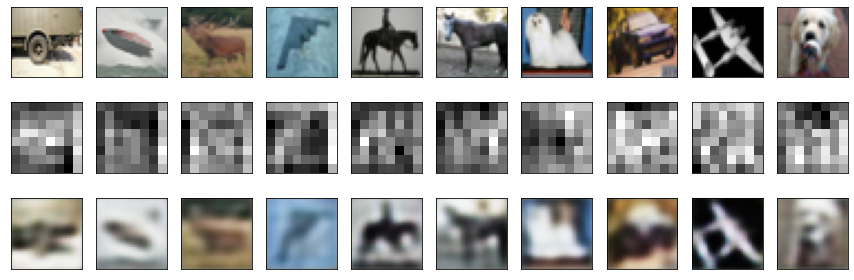

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# take 1 batch of the dataset
test_dataset = test_dataset.take(1)

# take the input images and put them in a list
output_samples = []
for input_image, image in tfds.as_numpy(test_dataset):
      output_samples = input_image

# pick 10 indices
idxs = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

# prepare test samples as a batch of 10 images
conv_output_samples = np.array(output_samples[idxs])
conv_output_samples = np.reshape(conv_output_samples, (10, 32, 32, 3))

# get the encoder ouput
encoded = convolutional_encoder_model.predict(conv_output_samples)

# get a prediction for some values in the dataset
predicted = model.predict(conv_output_samples)

# display the samples, encodings and decoded values!
display_results(conv_output_samples, encoded, predicted, enc_shape=(8,8))

## Save the model

In [10]:
model.save('mymodel.h5')